In [ ]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error
from keras.datasets import mnist
from keras import models
from keras import layers
from keras import optimizers
%matplotlib inline
plt.style.use('default')
import pandas_datareader.data as web
from datetime import datetime
end = datetime.now()
start = datetime(end.year-2, end.month, end.day)
import pandas.tseries
from statsmodels.tsa.stattools import adfuller
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.stattools import pacf
from statsmodels.tsa.arima_model import ARIMA
from scipy.stats import boxcox
import seaborn as sns
sns.set_style('whitegrid')
from matplotlib import colors
import warnings
warnings.filterwarnings('ignore')
from pandas.plotting import autocorrelation_plot
from pandas import concat
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from math import sqrt
from multiprocessing import cpu_count
import itertools

          MODEL FOR Microsoft       

In [ ]:
#Import the data set 

In [ ]:
MSFT = yf.Ticker('MSFT')

In [ ]:
Data = MSFT.history(period='max')

In [ ]:
# Define the date frame to 2010 and after 
Data= Data['2010':]

In [ ]:
#Review the Data 

In [ ]:
Stock=Data

In [ ]:
Stock.drop(columns=['Open','High','Low','Volume','Dividends','Stock Splits'],inplace=True)

In [ ]:
Stock['Year']=Stock.index.year
Stock['Month']=Stock.index.strftime('%B')
Stock['dayofweek']=Stock.index.strftime('%A')
Stock['quarter']=Stock.index.quarter
Stock

,Close,Year,Month,dayofweek,quarter
Date,,,,,
2010-01-04,23.800224,2010,January,Monday,1
2010-01-05,23.807913,2010,January,Tuesday,1
2010-01-06,23.661800,2010,January,Wednesday,1
2010-01-07,23.415726,2010,January,Thursday,1
2010-01-08,23.577211,2010,January,Friday,1
...,...,...,...,...,...
2022-05-25,262.519989,2022,May,Wednesday,2
2022-05-26,265.899994,2022,May,Thursday,2
2022-05-27,273.239990,2022,May,Friday,2


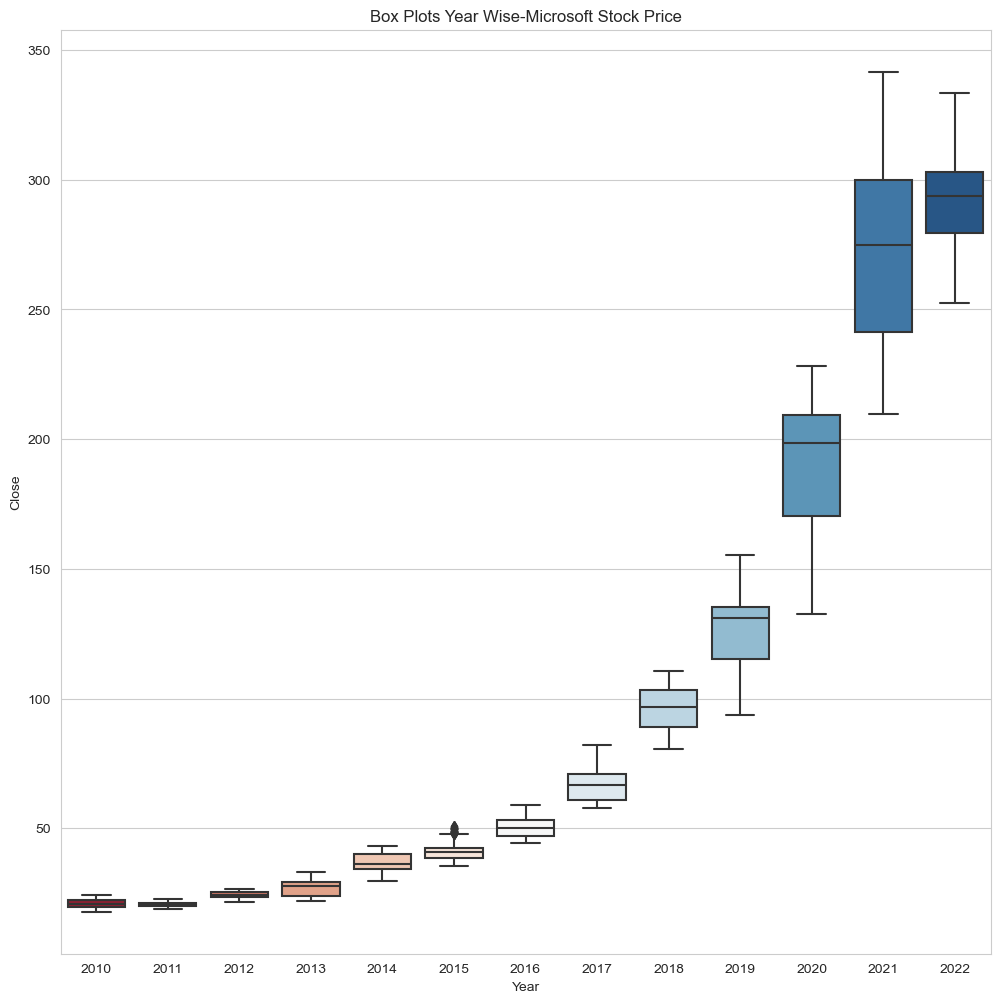

In [ ]:
plt.figure(figsize=(12,12))
ax=sns.boxplot(x=Stock['Year'],y=Stock['Close'],palette='RdBu')
ax.set_title('Box Plots Year Wise-Microsoft Stock Price')
plt.style.context('fivethirtyeight')

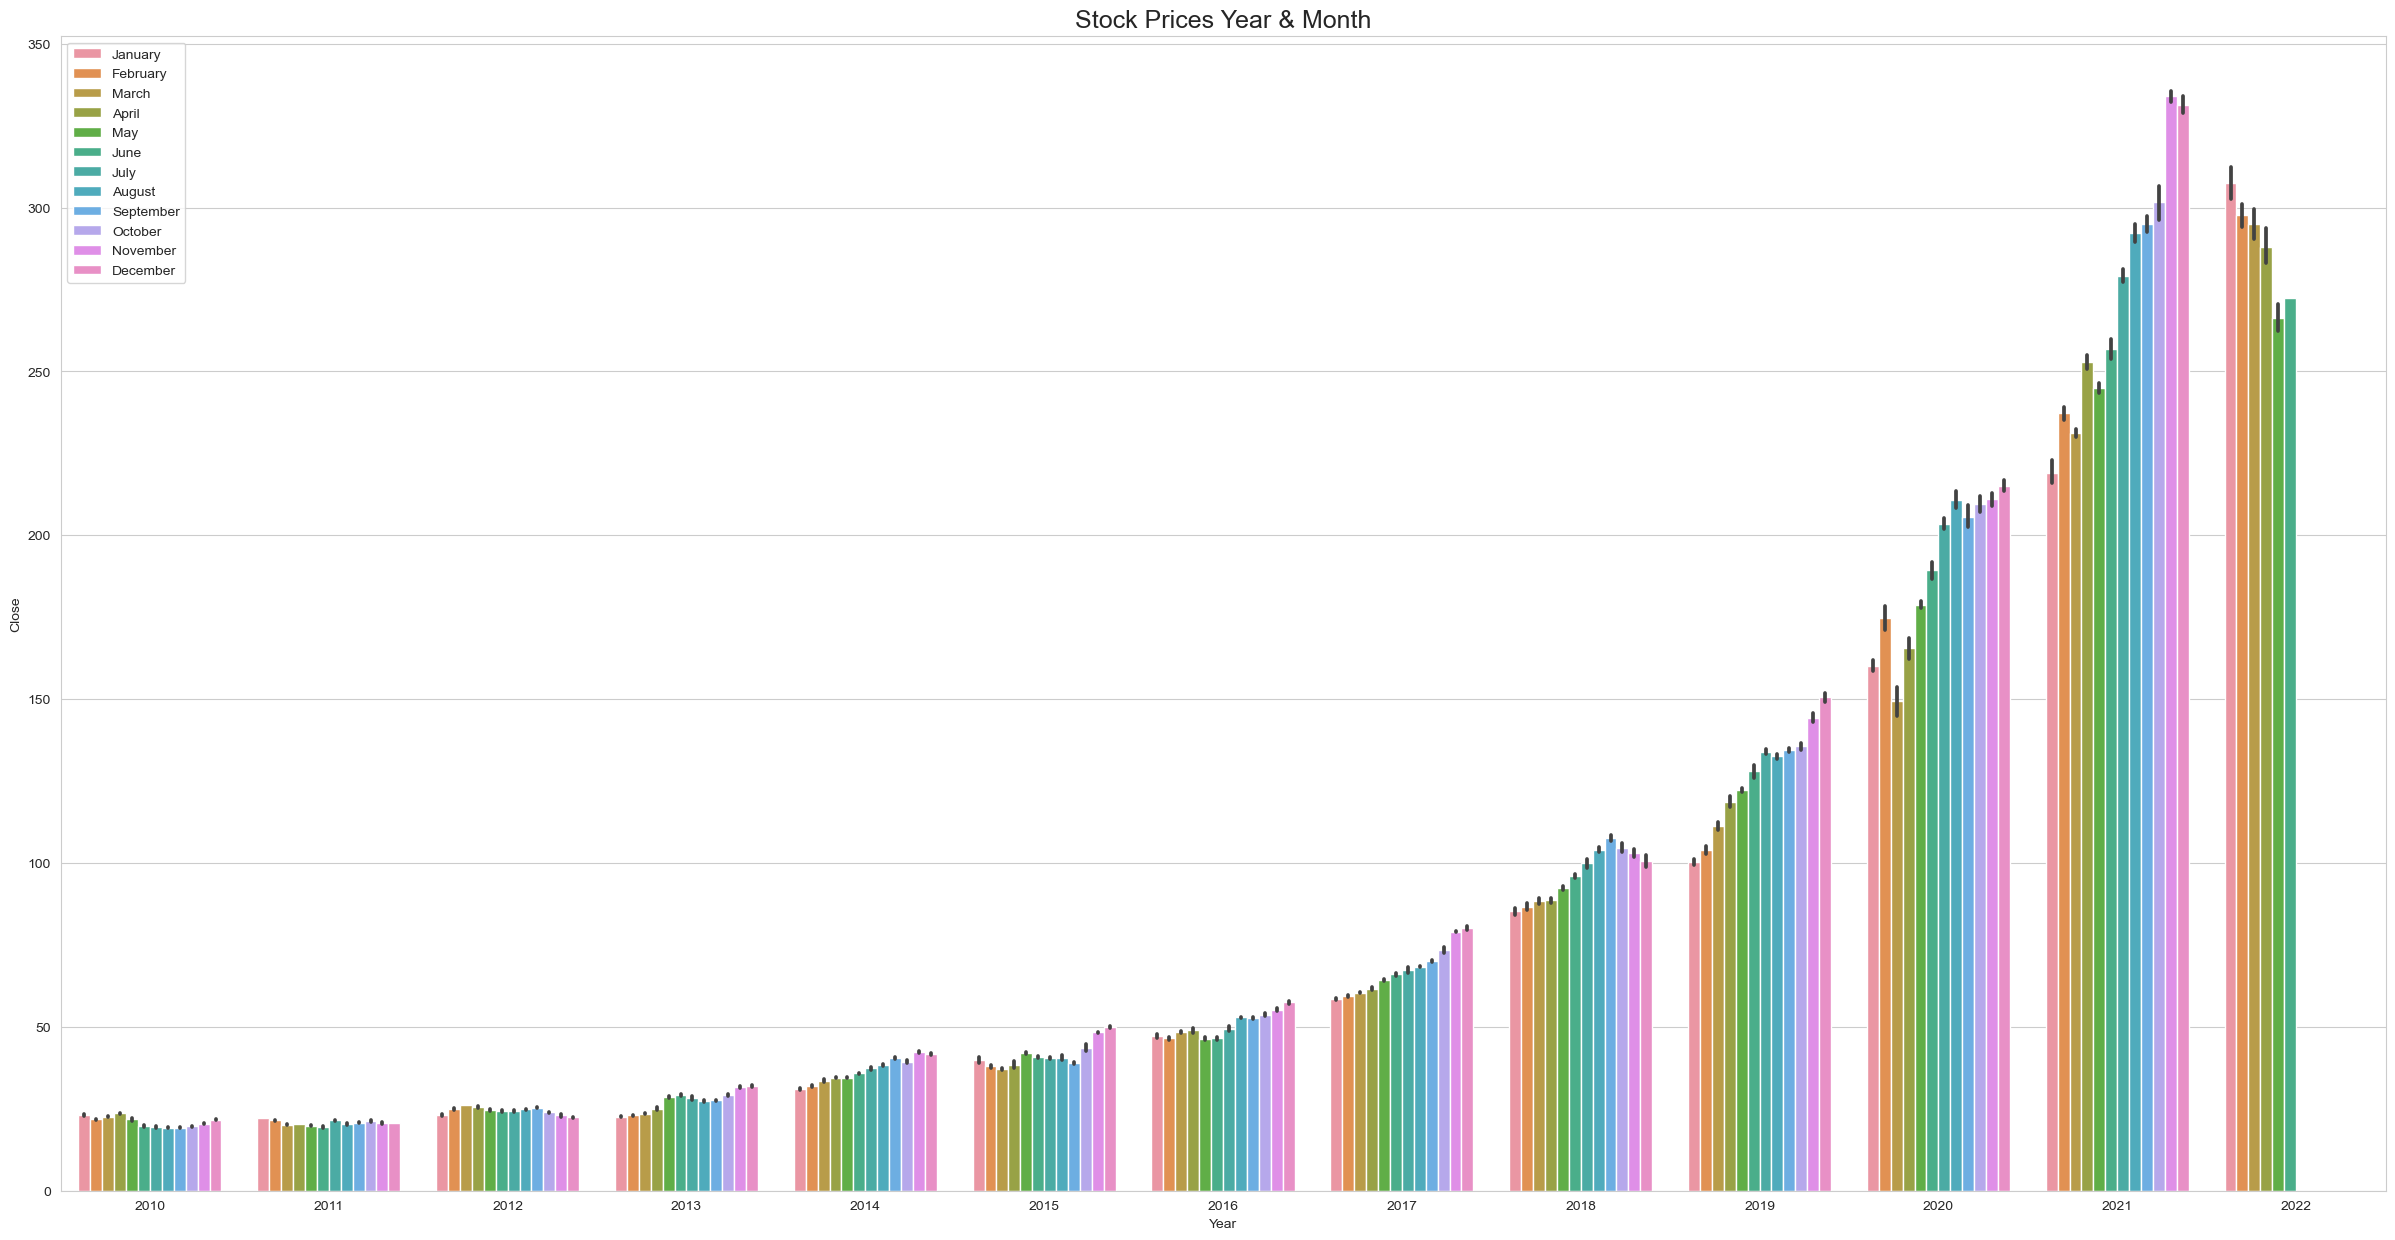

In [ ]:
fig,ax=plt.subplots(figsize=(30,15))
palette=sns.color_palette('mako_r',6)
a=sns.barplot(x='Year',y='Close',hue='Month',data=Stock)
a.set_title('Stock Prices Year & Month',fontsize=18)
plt.legend(loc='upper left')
plt.show()

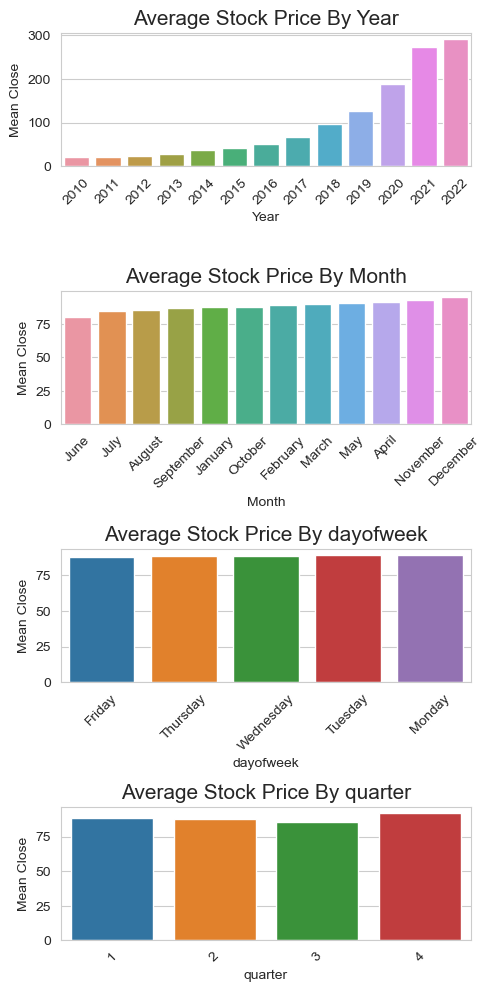

In [ ]:
fig = plt.figure(figsize=(5,10))
fig.set_size_inches(5,10)
group_cols = Stock.columns

for enum,i in enumerate(group_cols[1:]):
  ax = fig.add_subplot(4,1,enum+1)
  Aggregated = pd.DataFrame(Stock.groupby(str(i))["Close"].mean()).reset_index().sort_values('Close')
  sns.barplot(data=Aggregated,x=str(i),y="Close",ax=ax)
  ax.set(xlabel=str(i), ylabel='Mean Close')
  ax.set_title("Average Stock Price By {}".format(str(i)),fontsize=15)
  plt.xticks(rotation=45)
  
plt.tight_layout(pad=1)

In [ ]:
# Make the data ready for LSTM/GRU 

In [ ]:
# functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Microsoft Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Microsoft Stock Price')
    plt.title('Microsoft Stock Price Prediction')
    plt.xlabel('Time')
    plt.ylabel('Microsoft Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

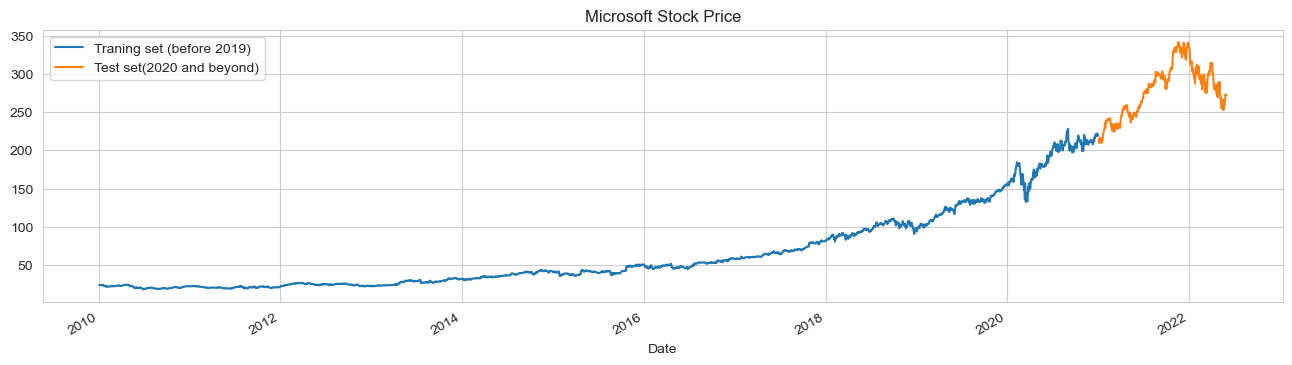

In [ ]:
#Plot High price 
Data['Close'][:'2020'].plot(figsize=(16,4),legend=True)
Data['Close']['2021':].plot(figsize=(16,4),legend=True)
plt.legend(['Traning set (before 2019)','Test set(2020 and beyond)'])
plt.title('Microsoft Stock Price')
plt.show()


In [ ]:
# creating vecor 
traning_set = Data[:'2020'].iloc[:,1:2].values
test_set = Data['2021':].iloc[:,1:2].values

In [ ]:
print(traning_set.shape,test_set.shape)

(2769, 1) (356, 1)


In [ ]:
#scaling the traning_set
sc=MinMaxScaler(feature_range=(0,1))
traning_set_scale = sc.fit_transform(traning_set)

In [ ]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60,2769):
    X_train.append(traning_set_scale[i-60:i,0])
    y_train.append(traning_set_scale[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [47]:
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=150)

Epoch 1/50
19/19 [==============================] - 16s 600ms/step - loss: 0.1435
Epoch 2/50
19/19 [==============================] - 13s 697ms/step - loss: 0.0523
Epoch 3/50
19/19 [==============================] - 13s 660ms/step - loss: 0.0071
Epoch 4/50
19/19 [==============================] - 14s 730ms/step - loss: 0.0032
Epoch 5/50
19/19 [==============================] - 12s 611ms/step - loss: 0.0026
Epoch 6/50
19/19 [==============================] - 14s 746ms/step - loss: 0.0022
Epoch 7/50
19/19 [==============================] - 12s 634ms/step - loss: 0.0022
Epoch 8/50
19/19 [==============================] - 11s 552ms/step - loss: 0.0020
Epoch 9/50
19/19 [==============================] - 12s 633ms/step - loss: 0.0020
Epoch 10/50
19/19 [==============================] - 13s 697ms/step - loss: 0.0019
Epoch 11/50
19/19 [==============================] - 13s 662ms/step - loss: 0.0019
Epoch 12/50
19/19 [==============================] - 11s 597ms/step - loss: 0.0017
Epoch 13/50
1

In [ ]:
# reorganize the data set 
dataset_total = pd.concat((Data["Close"][:'2019'],Data["Close"]['2020':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
inputs.shape

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,409):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

In [ ]:
# Gated Recurrent Units = GRU Model 

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=100, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,409):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
# Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)

           Model with diffretn time set with Less Noise - 2016:2017 

In [ ]:
Data_2 = Data['2010':'2017']

In [ ]:
Data_2['High'].plot()

In [ ]:
#Plot High price 
Data_2['High'][:'2015'].plot(figsize=(16,4),legend=True)
Data_2['High']['2016':].plot(figsize=(16,4),legend=True)
plt.legend(['Traning set (before 2015)','Test set(2016 and beyond)'])
plt.title('Microsoft Stock Price')
plt.show()

In [ ]:
# creating vecor 
traning_set = Data_2[:'2015'].iloc[:,1:2].values
test_set = Data_2['2016':].iloc[:,1:2].values

In [ ]:
print(traning_set.shape,test_set.shape)

In [ ]:
#scaling the traning_set
sc=MinMaxScaler(feature_range=(0,1))
traning_set_scale = sc.fit_transform(traning_set)

In [ ]:
# creating a data structure with 60 timesteps and 1 output
X_train = []
y_train = []
for i in range(60,1510):
    X_train.append(traning_set_scale[i-60:i,0])
    y_train.append(traning_set_scale[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)

In [ ]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

In [ ]:
 #The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=100, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
regressor.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Third LSTM layer
regressor.add(LSTM(units=100, return_sequences=True,input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=100))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=50,batch_size=150)

In [ ]:
# reorganize the data set 
dataset_total = pd.concat((Data_2["High"][:'2015'],Data_2["High"]['2016':]),axis=0)
inputs = dataset_total[len(dataset_total)-len(test_set) - 60:].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

In [ ]:
inputs.shape

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,563):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

In [ ]:
# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

In [ ]:
# Evaluating our model
return_rmse(test_set,predicted_stock_price)

In [ ]:
# Gated Recurrent Units = GRU Model 

In [ ]:
# The GRU architecture
regressorGRU = Sequential()
# First GRU layer with Dropout regularisation
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Second GRU layer
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Third GRU layer
regressorGRU.add(GRU(units=100, return_sequences=True, input_shape=(X_train.shape[1],1), activation='tanh'))
regressorGRU.add(Dropout(0.2))
# Fourth GRU layer
regressorGRU.add(GRU(units=100, activation='tanh'))
regressorGRU.add(Dropout(0.2))
# The output layer
regressorGRU.add(Dense(units=1))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(lr=0.01, decay=1e-7, momentum=0.9, nesterov=False),loss='mean_squared_error')
# Fitting to the training set
regressorGRU.fit(X_train,y_train,epochs=50,batch_size=150)

In [ ]:
# Preparing X_test and predicting the prices
X_test = []
for i in range(60,563):
    X_test.append(inputs[i-60:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))
GRU_predicted_stock_price = regressorGRU.predict(X_test)
GRU_predicted_stock_price = sc.inverse_transform(GRU_predicted_stock_price)

In [ ]:
 # Visualizing the results for GRU
plot_predictions(test_set,GRU_predicted_stock_price)

In [ ]:
# Evaluating GRU
return_rmse(test_set,GRU_predicted_stock_price)